# Marine Heatwave calculation 

Using this notebook to compute MHW diagnostics (duration and mean magnitude)

To Dos

-GWL1.2 needs to read the historical data from 2000 to 2006  -- done

-Need to check what period the threshold calculation uses -- now using GW1p2

-Need to change the variable name in the output file to reflect what it is

Did the calculations with megamem


In [1]:
import xarray as xr
from dask.distributed import Client
import dask.array as da
from dask import delayed
import numpy as np
import os
import matplotlib.pyplot as plt
from glob import glob

#### start a local Dask client

In [2]:
from dask.distributed import Client
import dask

# Set configuration options
dask.config.set({
    'distributed.comm.timeouts.connect': '90s',  # Timeout for connecting to a worker
    'distributed.comm.timeouts.tcp': '90s',  # Timeout for TCP communications
})

#cluster = LocalCluster(
#    n_workers=28,          # Number of workers
#    threads_per_worker=1 #Threads per worker
#    #memory_limit='8GB' # Memory limit per each worker commented out
#)
#client = Client(cluster)

client = Client()
client

2024-06-23 21:45:52,213 - distributed.preloading - INFO - Creating preload: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py
2024-06-23 21:45:52,219 - distributed.utils - INFO - Reload module schedplugin from .py file
2024-06-23 21:45:52,225 - distributed.preloading - INFO - Import preload module: /g/data/hh5/public/apps/dask-optimiser/schedplugin.py


Modifying workers


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /node/gadi-mmem-bdw-0001.gadi.nci.org.au/65096/proxy/8787/status,
Dashboard: /node/gadi-mmem-bdw-0001.gadi.nci.org.au/65096/proxy/8787/status,Workers: 32
Total threads: 32,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:39787,Workers: 32
Dashboard: /node/gadi-mmem-bdw-0001.gadi.nci.org.au/65096/proxy/8787/status,Total threads: 32
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:32879,Total threads: 1
Dashboard: /node/gadi-mmem-bdw-0001.gadi.nci.org.au/65096/proxy/38507/status,Memory: 0 B
Nanny: tcp://127.0.0.1:34573,


In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
coords_to_drop =['st_edges_ocean','nv','st_ocean']
vars_to_drop =['Time_bounds','average_DT','average_T1','average_T2','st_ocean']

# preprocesser to drop unwanted variables
def drop_stuff(ds, coords_to_drop,vars_to_drop):
    """
    Preprocessor function to drop specified coordinates and variables from a dataset loaded via xr.open_mfdataset

    Parameters:
        ds (xarray.Dataset): The dataset from which coordinates & variables are to be dropped.
        coords_to_drop (list of str): List of coordinate names to drop.
        vars_to_drop(list of str): List of variable names to drop

    Returns:
        xarray.Dataset: Dataset with specified coordinates and variables dropped.
    """
    # Drop coordinates if they are in the dataset
    ds = ds.drop_vars(coords_to_drop, errors='ignore')
    ds = ds.drop_vars(vars_to_drop, errors='ignore')
    return ds

In [6]:
def process_threshold(ds, time_dim, start, end, variable, period):
    # Rechunk the data along the time dimension
    data = getattr(ds, variable).sel(**{time_dim: slice(start, end)}).chunk({'Time': -1, 'xt_ocean': 50, 'yt_ocean': 50}).persist()

    # Debug: Print the shape and chunking of the data
    print(f"Processing period {period}, data shape: {data.shape}, chunks: {data.chunks}")

    # Calculate the 90th percentile
    percentile_90 = data.groupby('Time.month').quantile(0.9, dim='Time').compute()
    percentile_90 = data.groupby('Time.dayofyear').quantile(0.9, dim='Time').compute()

    # Convert the result back to an xarray DataArray
    percentile_90_da = xr.DataArray(
        percentile_90,
         coords={
            'xt_ocean': data.coords['xt_ocean'],
            'yt_ocean': data.coords['yt_ocean'],
            'month': np.arange(1, 13)
        },
        dims=['dayofyear', 'yt_ocean', 'xt_ocean']
    )

    # Define the output file path
    file_path_90th = f'/g/data/ia39/ncra/ocean/peacey/{variable}_percentile_monthly__{period}.nc'

    # Save 90th percentile as netCDF
    percentile_90_da.to_netcdf(file_path_90th, compute=True)

In [7]:
# Define the periods for processing
GWL_periods = {
    'current': ('1995-01-01', '2014-12-31'),
    'GW1p2': ('2001-01-01', '2020-12-31'),
    'GW1p5': ('2015-01-01', '2034-12-31'),
    'GW2p0': ('2030-01-01', '2049-12-31'),
    'GW3p0': ('2053-01-01', '2072-12-31'),
    'GW4p0': ('2074-01-01', '2093-12-31')
}

# Directory paths for SST
dir1_new = '/g/data/fp2/OFAM3/jra55_historical.1/surface/'
dir2_new = '/g/data/fp2/OFAM3/jra55_rcp8p5/surface/'

# Load datasets with chunking
pattern0=sorted(glob(dir1_new + 'ocean_temp_sfc*.nc'))
# need to get the additional data from historical run to cover the early 2000s
pattern1=sorted(glob(dir1_new + 'ocean_temp_sfc*200[0-5]*.nc'))
pattern2=sorted(glob(dir2_new + 'ocean_temp_sfc*.nc'))

dsst1 = xr.open_mfdataset(pattern0, parallel=True, 
        preprocess = lambda x: drop_stuff(x,coords_to_drop, vars_to_drop)).squeeze()
dsst2 = xr.open_mfdataset(pattern1+pattern2, parallel=True, 
        preprocess = lambda x: drop_stuff(x,coords_to_drop, vars_to_drop)).squeeze()


In [8]:
dsst1

<xarray.Dataset> Size: 284GB
Dimensions:   (Time: 13149, yt_ocean: 1500, xt_ocean: 3600)
Coordinates:
  * Time      (Time) datetime64[ns] 105kB 1979-01-01T12:00:00 ... 2014-12-31T...
  * xt_ocean  (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
Data variables:
    temp      (Time, yt_ocean, xt_ocean) float32 284GB dask.array<chunksize=(31, 1500, 3600), meta=np.ndarray>
Attributes:
    filename:       TMP/ocean_ofam_1979_01.nc.0000
    NumFilesInSet:  720
    title:          jra_55_1979
    grid_type:      regular
    history:        Mon Mar 16 09:51:50 2015: ncks -d st_ocean,0 ../daily/oce...
    NCO:            4.3.8

## Doing the MHW calculation 

In [37]:

sst=dsst2.temp
sst1=sst
sst1 = sst1.rename({"Time":"time"})

period='GW4p0'
s=GWL_periods[period]
print(s[0],s[1])

sst1= sst1.sel(time=slice(s[0],s[1]))    #'2001-01-01', '2020-12-31'))

# number of years in the slice
nshape= np.shape(sst1)
nyears=np.int(nshape[0]/365.25+.5)
print(nyears)

sst1

2074-01-01 2093-12-31
20


<xarray.DataArray 'temp' (time: 7305, yt_ocean: 1500, xt_ocean: 3600)> Size: 158GB
dask.array<getitem, shape=(7305, 1500, 3600), dtype=float32, chunksize=(31, 1500, 3600), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 58kB 2074-01-01T12:00:00 ... 2093-12-31T1...
  * xt_ocean  (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean  (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.75 74.85 74.95
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [38]:
%%time
#threshold90 =  xr.open_dataset('/g/data/ia39/ncra/ocean/peacey/mhw/temp_90th_percentile_current.nc')['temp']
threshold90 =  xr.open_dataset('/g/data/ia39/ncra/ocean/peacey/mhw/temp_90th_percentile_GW1p2.nc')['temp']
#threshold90 = threshold90.chunk({'yt_ocean': 50, 'xt_ocean': 50})
threshold90 = threshold90.chunk({'dayofyear': 31})
# only needed if reduce the size of the spatial domain
#threshold90 = threshold90.isel(yt_ocean=slice(y1,y2), xt_ocean=slice(x1,x2))
threshold90

CPU times: user 12.6 ms, sys: 17.8 ms, total: 30.4 ms
Wall time: 21.5 ms


<xarray.DataArray 'temp' (dayofyear: 366, yt_ocean: 1500, xt_ocean: 3600)> Size: 16GB
dask.array<xarray-<this-array>, shape=(366, 1500, 3600), dtype=float64, chunksize=(31, 1500, 3600), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean   (xt_ocean) float64 29kB 0.05 0.15 0.25 0.35 ... 359.8 359.9 360.0
  * yt_ocean   (yt_ocean) float64 12kB -74.95 -74.85 -74.75 ... 74.85 74.95
  * dayofyear  (dayofyear) int64 3kB 1 2 3 4 5 6 7 ... 361 362 363 364 365 366
Attributes:
    long_name:      Potential temperature
    units:          degrees C
    valid_range:    [-32767  32767]
    packing:        4
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_potential_temperature

In [39]:
%%time
# MHW 

# Expand threshold90 to match the original time series, and dropping "dayofyear"
expanded_threshold = threshold90.sel(dayofyear=sst1['time'].dt.dayofyear)
expanded_threshold = expanded_threshold.drop('dayofyear')

# Remove threshold from sst data
diff = sst1 - expanded_threshold
#diff.plot()

# Find period where threshold is positive for min_dur days
min_dur=10
hmask= sst1 > expanded_threshold
# must satisfy min_dur with the shift required to get first min_dur -1 days
hmask1 = hmask.rolling(time=min_dur, center=False).sum() >= min_dur
hmask2 = hmask1.shift(time=((min_dur-1)*-1),fill_value=False)

hmask3= hmask1 | hmask2

# duration in days/y and mean magnitude over all heatwaves in the period
dur_mhw=(hmask3.sum('time')/nyears)
mag_mhw=( (hmask3*diff).mean('time') ) #/dur_mhw)


CPU times: user 427 ms, sys: 63.6 ms, total: 490 ms
Wall time: 490 ms


In [40]:
%%time
# save duration and magnitude to a file
dur_mhw.to_netcdf("/scratch/xv83/rxm599/dur_"+period+".nc")
mag_mhw.to_netcdf("/scratch/xv83/rxm599/mag_"+period+".nc")

CPU times: user 5min 59s, sys: 1min 56s, total: 7min 55s
Wall time: 12min 4s


## Check the output 

In [41]:
dur=xr.open_dataset('/scratch/xv83/rxm599/dur_'+period+'.nc')
mag=xr.open_dataset('/scratch/xv83/rxm599/mag_'+period+'.nc')

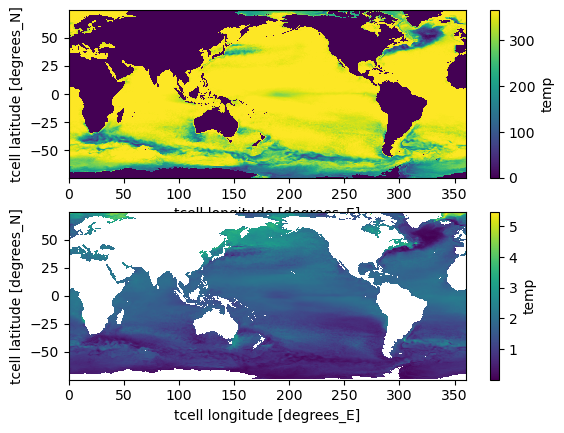

In [42]:
plt.subplot(2,1,1); dur.temp.plot()
plt.subplot(2,1,2); mag.temp.plot()

In [43]:
print(period)
GWL_periods[period]

GW4p0


('2074-01-01', '2093-12-31')

# Process SST
for period, (start, end) in GWL_periods.items():
    if period == 'current':
        process_threshold(dsst1, 'Time', start, end, 'temp', period)
    else:
        process_threshold(dsst2, 'Time', start, end, 'temp', period)

client.close()